# Getting parameters from runs with py3DCORE_h4c

In [2]:
%load_ext autoreload

%autoreload 2

import heliosat as heliosat
import logging as logging
import datetime as datetime
import numpy as np
import os as os
import pickle as pickle
import py3dcore_h4c as py3dcore_h4c
import matplotlib.pyplot as plt
import pandas as pds
import seaborn as sns

In [3]:
from heliosat.util import sanitize_dt

logging.basicConfig(level=logging.INFO)
logging.getLogger("heliosat.spice").setLevel("WARNING")
logging.getLogger("heliosat.spacecraft").setLevel("WARNING")

For plotting, we need the following information about the times.

In [4]:
t_launch = datetime.datetime(2022, 6, 2, 6, tzinfo=datetime.timezone.utc)

t_s_psp = datetime.datetime(2022, 6, 2, 10, tzinfo=datetime.timezone.utc)
t_e_psp = datetime.datetime(2022, 6, 3, 6, tzinfo=datetime.timezone.utc)

t_psp = [
    datetime.datetime(2022, 6, 2, 13, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 6, 2, 14, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 6, 2, 15, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 6, 2, 16, tzinfo=datetime.timezone.utc)
]

In [6]:
file = pickle.load(open('py3dcore_h4c/custom_data/solo_2022sep.p', 'rb'))
data = pds.DataFrame(file)
print(data)

                     time        bx         by        bz         bt         r  \
0     2022-08-31 00:00:00  0.029020 -16.435475 -8.135658  18.338882  0.757695   
1     2022-08-31 00:01:00  0.029020 -16.435475 -8.135658  18.338882  0.757689   
2     2022-08-31 00:02:00  0.029020 -16.435475 -8.135658  18.338882  0.757682   
3     2022-08-31 00:03:00  0.029020 -16.435475 -8.135658  18.338882  0.757676   
4     2022-08-31 00:04:00  0.758405 -15.021704 -8.239454  17.149792  0.757670   
...                   ...       ...        ...       ...        ...       ...   
18715 2022-09-12 23:55:00  9.965065  -4.377737 -0.034102  10.884313  0.624461   
18716 2022-09-12 23:56:00  9.458576  -4.851109 -0.793987  10.659660  0.624453   
18717 2022-09-12 23:57:00  8.093511  -5.018920 -1.481281   9.637877  0.624445   
18718 2022-09-12 23:58:00  6.810724  -5.369940 -2.262874   8.963415  0.624437   
18719 2022-09-12 23:59:00  9.848583  -4.932434 -1.495545  11.115761  0.624429   

            lat         lon

In [4]:
# specify directory from which to read pickle file (= results of runs)
path = 'psp02062022_heeq_1024_4FP/'

# Get the list of all files in path
dir_list = sorted(os.listdir(path))

resfile = []
respath = []
# we only want the pickle-files
for file in dir_list:
    if file.endswith(".pickle"):
        resfile.append(file) 
        respath.append(os.path.join(path,file))
        print(os.path.join(path, file))       

psp02062022_heeq_1024_4FP/00.pickle
psp02062022_heeq_1024_4FP/01.pickle
psp02062022_heeq_1024_4FP/02.pickle
psp02062022_heeq_1024_4FP/03.pickle
psp02062022_heeq_1024_4FP/04.pickle
psp02062022_heeq_1024_4FP/05.pickle
psp02062022_heeq_1024_4FP/06.pickle
psp02062022_heeq_1024_4FP/07.pickle
psp02062022_heeq_1024_4FP/08.pickle


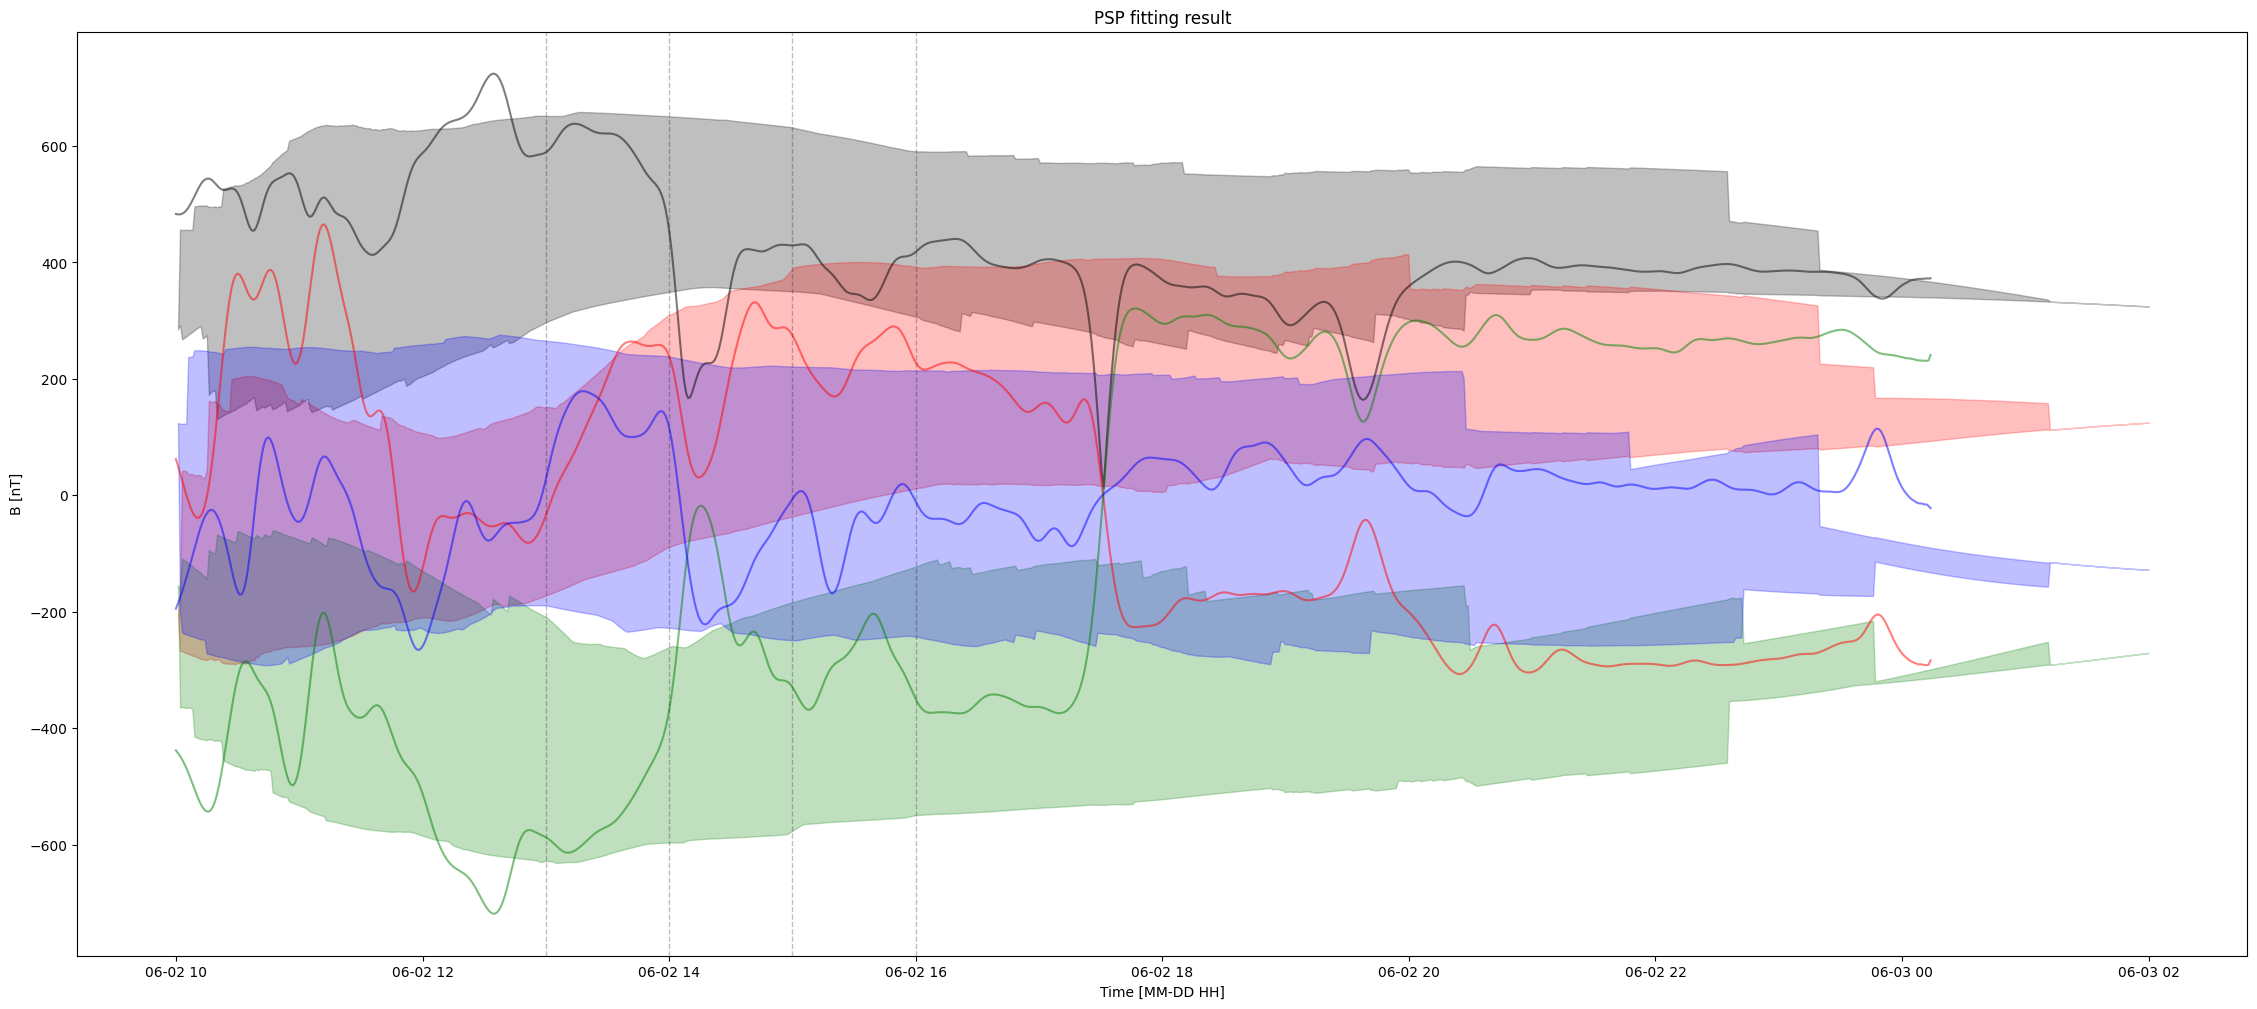

In [5]:
# plot the results 

t_s_psp = datetime.datetime(2022, 6, 2, 10, tzinfo=datetime.timezone.utc)
t_e_psp = datetime.datetime(2022, 6, 3, 2, tzinfo=datetime.timezone.utc)

# get measurements from PSP via heliosat
psp_t, psp_b = heliosat.PSP().get([t_s_psp, t_e_psp], "mag", reference_frame="HEEQ", as_endpoints=True, return_datetimes=True, smoothing="gaussian")

# get ensemble_data
ed = py3dcore_h4c.generate_ensemble(respath[-1], psp_t, reference_frame="HEEQ", reference_frame_to="HEEQ", max_index=128)

plt.figure(figsize=(28, 12))
plt.title("PSP fitting result")
plt.plot(psp_t, np.sqrt(np.sum(psp_b**2, axis=1)), "k", alpha=0.5)
plt.plot(psp_t, psp_b[:, 0], "r", alpha=0.5)
plt.plot(psp_t, psp_b[:, 1], "g", alpha=0.5)
plt.plot(psp_t, psp_b[:, 2], "b", alpha=0.5)
plt.fill_between(psp_t, ed[0][3][0], ed[0][3][1], alpha=0.25, color="k")
plt.fill_between(psp_t, ed[0][2][0][:, 0], ed[0][2][1][:, 0], alpha=0.25, color="r")
plt.fill_between(psp_t, ed[0][2][0][:, 1], ed[0][2][1][:, 1], alpha=0.25, color="g")
plt.fill_between(psp_t, ed[0][2][0][:, 2], ed[0][2][1][:, 2], alpha=0.25, color="b")
plt.ylabel("B [nT]")
plt.xlabel("Time [MM-DD HH]")
for _ in t_psp:
    plt.axvline(x=_, lw=1, alpha=0.25, color="k", ls="--")
plt.savefig(path+'%s.png' %resfile[-1])    
plt.show()

In [6]:
# read from pickle file
file = open(respath[-1], "rb")
data = pickle.load(file)
file.close()

# get overview of whats in pickle file
cnt = 0
for item in data:
    print(item)
    cnt += 1
    
# get index ip for run with minimum eps    
epses_t = data["epses"]
ip = np.argmin(epses_t)    

# get parameters (stored in iparams_arr) for the run with minimum eps
model_objt = data["model_obj"]
iparams_arrt = model_objt.iparams_arr
iparams_arrt[ip]

locked
dt_0
model_kwargs
observers
model
iter_i
hist_eps
hist_time
hist_eps_dim
model_obj
data_obj
epses


array([ 0.00000000e+00, -1.03218544e+02, -1.79749527e+01,  1.42908630e+01,
        3.17273140e-01,  2.93962908e+00,  4.00111914e+00,  5.82574036e+02,
        6.53710251e+01,  1.13999999e+00,  1.63999999e+00,  5.41104794e+00,
        1.36855614e+00,  3.18037537e+02], dtype=float32)

In [9]:
data

{'locked': False,
 'dt_0': datetime.datetime(2022, 6, 2, 6, 0, tzinfo=datetime.timezone.utc),
 'model_kwargs': {'ensemble_size': 65536,
  'iparams': {'cme_longitude': {'maximum': -50, 'minimum': -150},
   'cme_latitude': {'maximum': 50, 'minimum': -50},
   'cme_inclination': {'maximum': 50, 'minimum': 0},
   'cme_launch_velocity': {'maximum': 900, 'minimum': 100},
   'cme_launch_radius': {'distribution': 'uniform',
    'maximum': 15,
    'minimum': 3}}},
 'observers': [['PSP',
   [datetime.datetime(2022, 6, 2, 13, 0, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 6, 2, 14, 0, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 6, 2, 15, 0, tzinfo=datetime.timezone.utc),
    datetime.datetime(2022, 6, 2, 16, 0, tzinfo=datetime.timezone.utc)],
   datetime.datetime(2022, 6, 2, 10, 0, tzinfo=datetime.timezone.utc),
   datetime.datetime(2022, 6, 3, 6, 0, tzinfo=datetime.timezone.utc),
   None]],
 'model': py3dcore_h4c.models.toroidal.ToroidalModel,
 'iter_i': 9,
 'hist_ep

## Use scatter plot to plot range of all runs

In [7]:
df = pds.DataFrame(iparams_arrt)
cols = df.columns.values.tolist()

# drop first column, and others in which you are not interested
df.drop(df.columns[[0, 9, 10]], axis=1, inplace=True)

# rename columns
df.columns = ['lon', 'lat', 'inc', 'D1AU', 'delta', 'launch radius', 'init speed', 't factor', 'B1AU', 'gamma', 'vsw']
print(df.head())

          lon        lat        inc      D1AU     delta  launch radius  \
0 -112.423584 -30.463552  14.742974  0.142850  2.344738       9.579621   
1 -107.532036 -28.316357  24.209429  0.264118  2.855276       4.254158   
2 -109.883331 -33.596737  13.933313  0.237708  3.514317      11.757202   
3  -94.934235 -37.476910  17.074848  0.296138  3.252492      14.506837   
4 -109.822517   0.832848   0.877335  0.296823  2.778223       9.206443   

   init speed    t factor      B1AU     gamma         vsw  
0  672.355164  -62.883400  7.049441  1.260261  323.477173  
1  636.242920  145.993362  7.248744  0.897515  446.762787  
2  473.317505   16.923088  5.171669  1.690519  385.653992  
3  256.606689  -68.387810  7.069561  1.548243  369.700775  
4  453.573303   47.844074  6.341797  1.977432  333.877869  


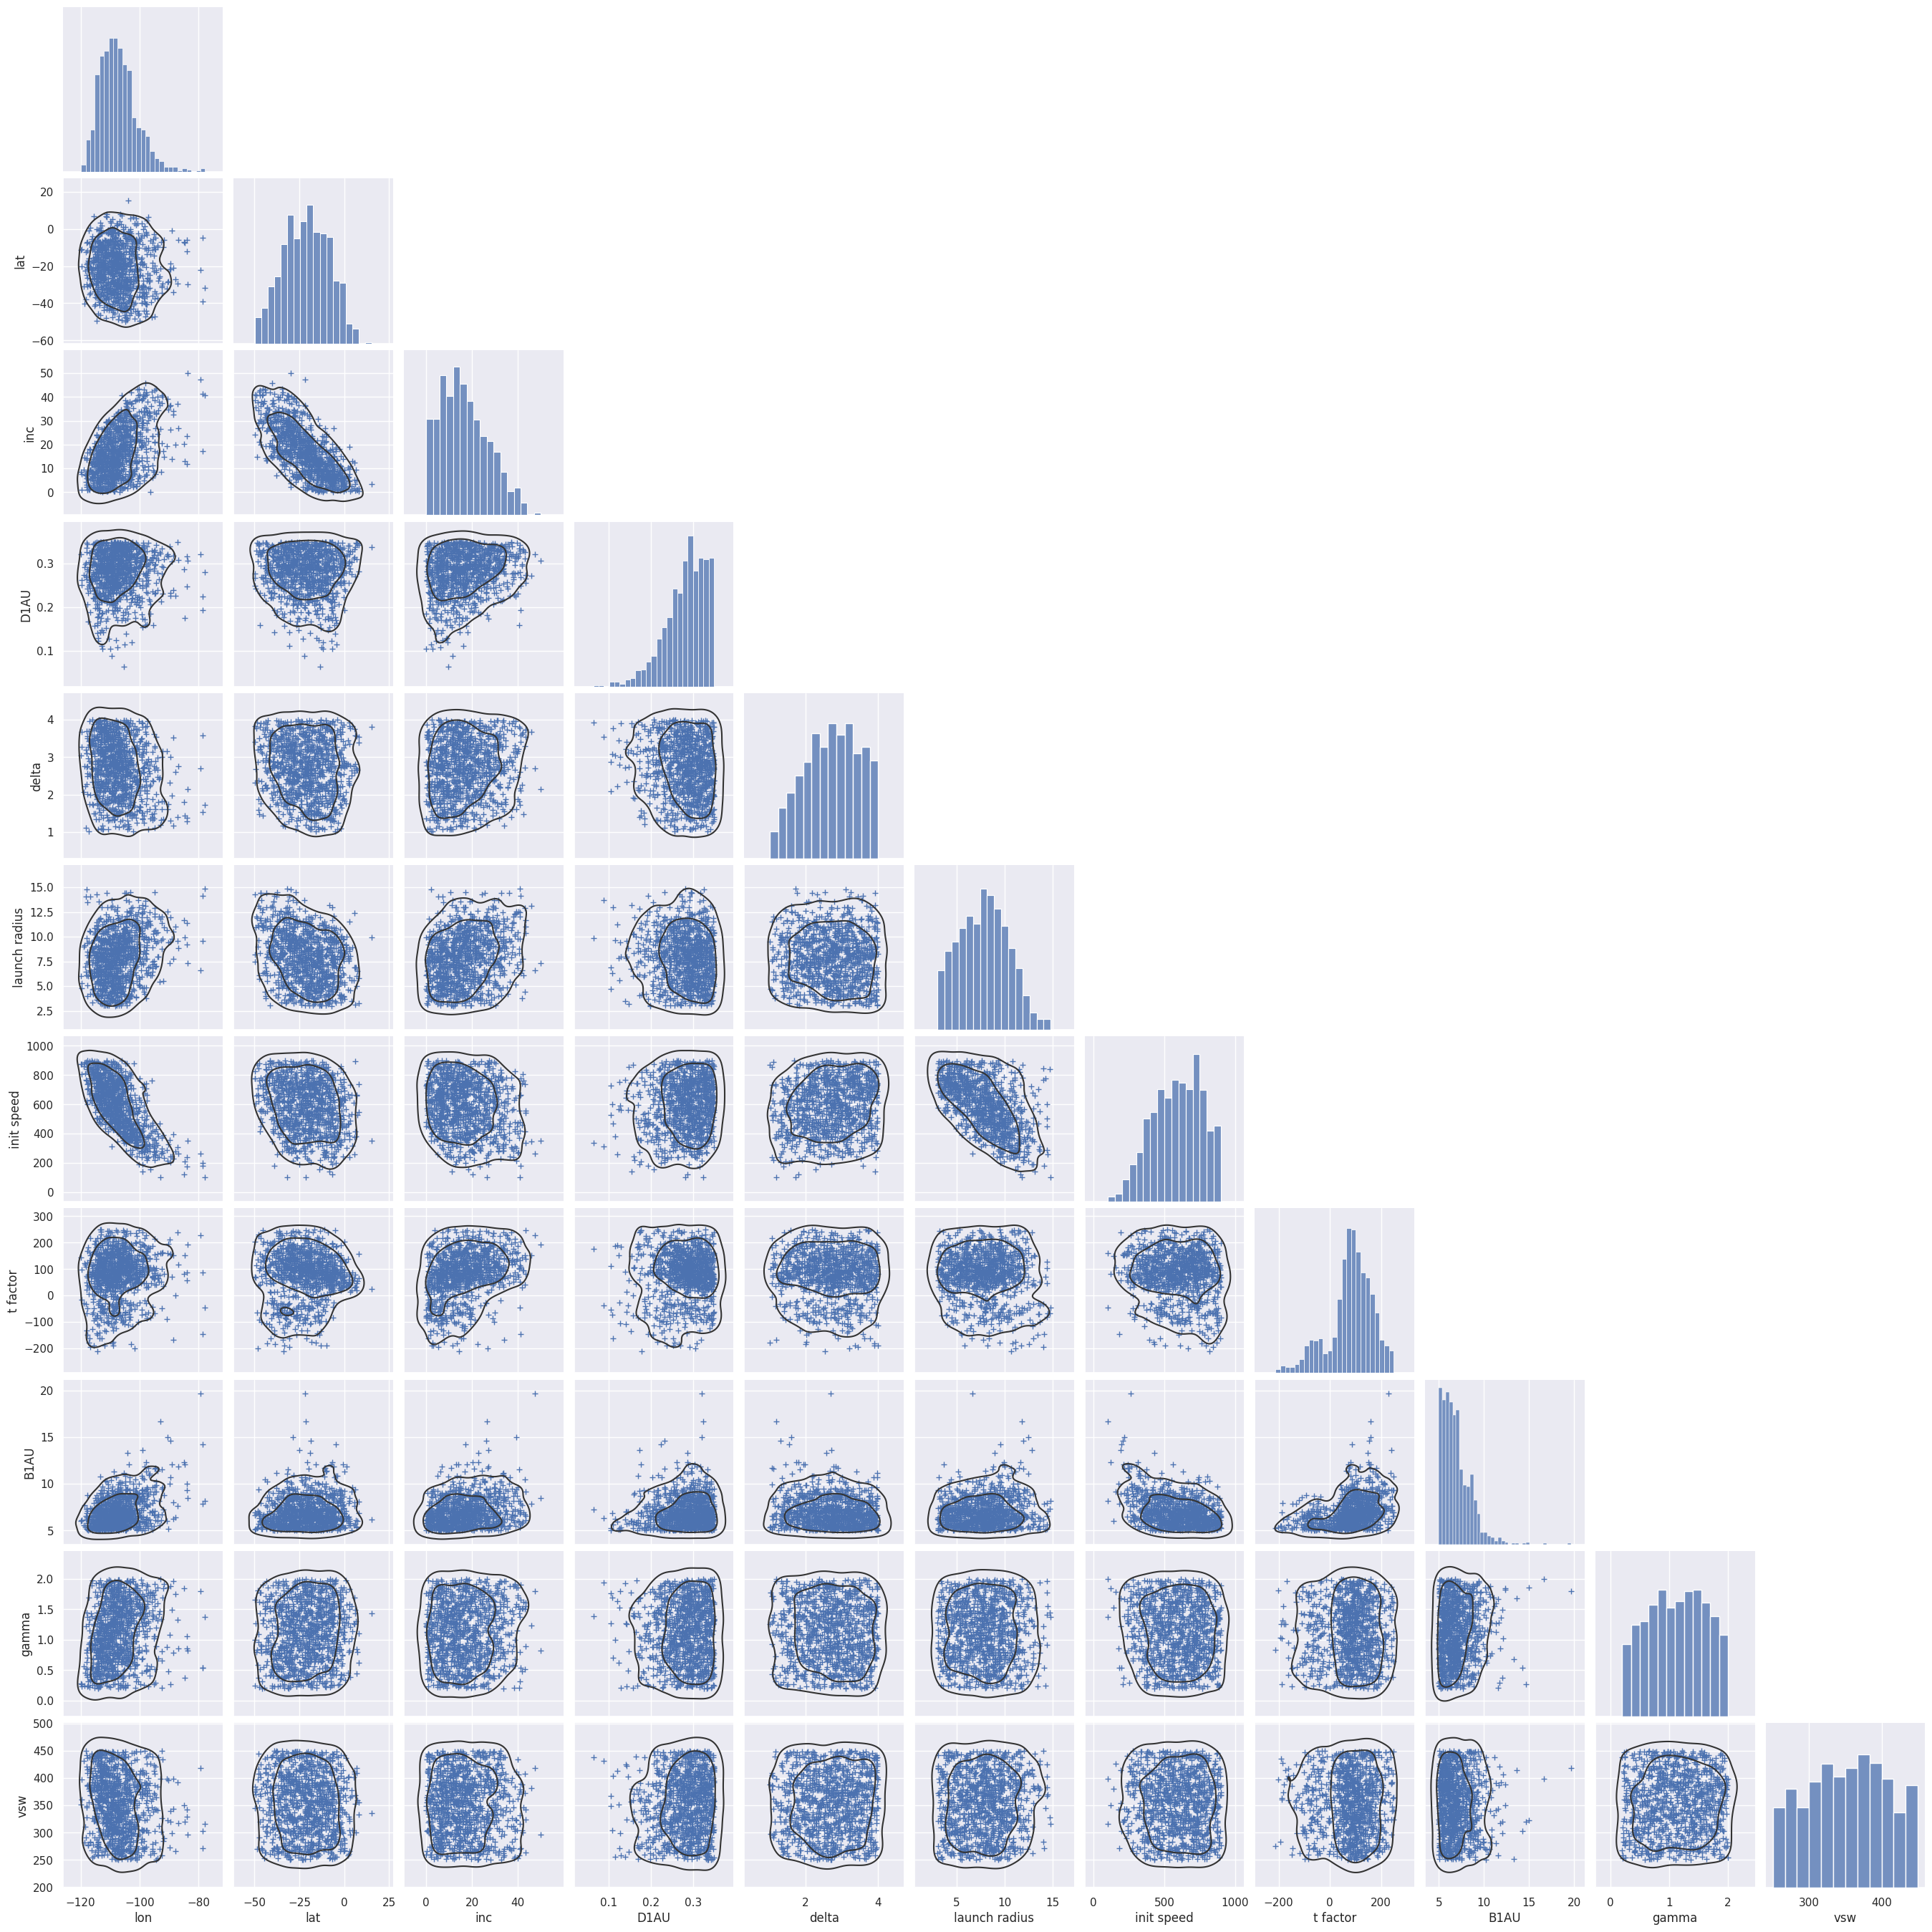

In [8]:
sns.set_style('white')
sns.set()

g = sns.pairplot(df, 
                 corner=True,
                 plot_kws=dict(marker="+", linewidth=1)
                )
g.map_lower(sns.kdeplot, levels=[0.05, 0.32], color=".2") #  levels are 2-sigma and 1-sigma contours
g.savefig(path+'scatter_plot_matrix.png')
plt.show()